In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import optuna
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the dataset
train_df = pd.read_csv('../Modified Datasets/data_missing_clean_and_pruned.csv')
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.0,22.732803,0,2,1,180.3,4,1,0,2,...,228.0,218.571429,0,0,0,0,0,0,0,1
1,77.0,27.421875,0,2,0,160.0,4,1,0,5,...,51.0,51.000000,0,0,0,0,0,0,0,1
2,25.0,31.952749,0,2,0,172.7,3,0,0,5,...,228.0,218.571429,0,0,0,0,0,0,0,0
3,81.0,22.635548,1,2,0,165.1,8,2,0,2,...,337.0,337.000000,0,0,0,0,0,0,0,0
4,19.0,27.562370,0,2,1,188.0,3,0,0,5,...,228.0,218.571429,0,0,0,0,0,0,0,0


In [3]:
X = train_df.drop(['diabetes_mellitus'], axis=1)
y = train_df['diabetes_mellitus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify=y)

In [4]:
model_results = []

In [5]:
def calculate_scores(model_name, y_test, y_pred, score):
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return {
        "model": model_name,
        "roc_auc_score": score,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

#### Logistic Regression

In [6]:
ridge_classifier = RidgeClassifier(alpha=0.2, fit_intercept=True, solver='svd')
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)
score = roc_auc_score(y_test, ridge_classifier._predict_proba_lr(X_test)[:, 1])

In [7]:
ridge_classifier_result = calculate_scores("Ridge Classifier", y_test, y_pred, score)
model_results.append(ridge_classifier_result)

#### Decision Trees Classifier Experiments


In [69]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
path = decision_tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [77]:
len(ccp_alphas)

5088

In [97]:
clfs = []
for ccp_alpha in ccp_alphas[-20:]:
    clf = DecisionTreeClassifier(random_state=12, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [98]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_test, y_test) for clf in clfs]

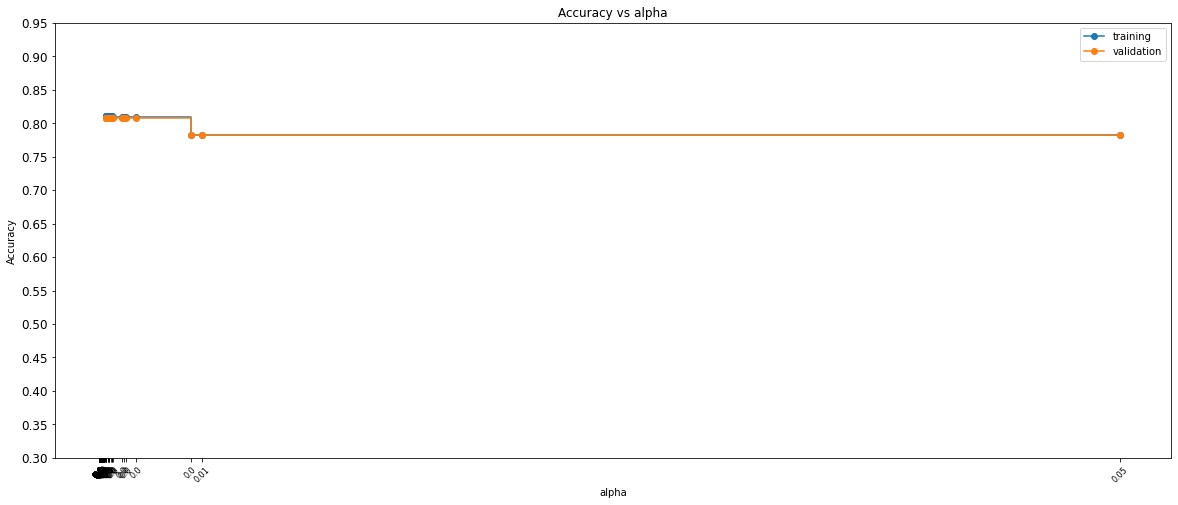

In [99]:
plt.figure(figsize = (20,8))
plt.plot(ccp_alphas[-20:], train_scores,marker='o', label="training",
        drawstyle="steps-post")
plt.plot(ccp_alphas[-20:], valid_scores, marker='o', label="validation",
        drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs alpha")
plt.legend()
rounded_ccp = [ round(elem, 2) for elem in ccp_alphas ]
locs, labels = plt.xticks()
plt.xticks(ccp_alphas, rounded_ccp, rotation = 45, fontsize = 8)
plt.yticks(np.arange(0.3,1,0.05), fontsize = 12)
plt.show()

In [100]:
optimal_ccp = ccp_alphas[-20]
decision_tree_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00033742649395846445, random_state=42)

In [104]:
y_preds = decision_tree_classifier.predict(X_test)
score = roc_auc_score(y_test, decision_tree_classifier.predict_proba(X_test)[:, 1])
decision_tree_classifier_result = calculate_scores("Decision Tree Classifier", y_test, y_preds, score)
model_results.append(decision_tree_classifier_result)

#### XGBoost Classifier Experiments

In [13]:
def model_fit(alg, X_train, y_train, X_test, y_test, use_train_cv=True, cv_folds=5, early_stopping=50):
    if use_train_cv:
        xgb_params = alg.get_xgb_params()
        
        xg_train = xgb.DMatrix(X_train, label=y_train)
        cv_result = xgb.cv(xgb_params, xg_train, num_boost_round=alg.get_params()['n_estimators'],
                            metrics='auc', early_stopping_rounds=early_stopping)
        alg.set_params(n_estimators=cv_result.shape[0])

    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')

    # Predict training set
    train_predictions = alg.predict(X_train)
    train_pred_prob = alg.predict_proba(X_train)[:, 1]

    # Print model report
    print("Accuracy : %.4g" % accuracy_score(y_train, train_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, train_pred_prob))
    print("AUC Score (Test): %f" % roc_auc_score(y_test, alg.predict_proba(X_test)[:, 1]))

    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)

    plt.figure(figsize=(30, 12))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy : 0.876
AUC Score (Train): 0.919869
AUC Score (Test): 0.853815


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


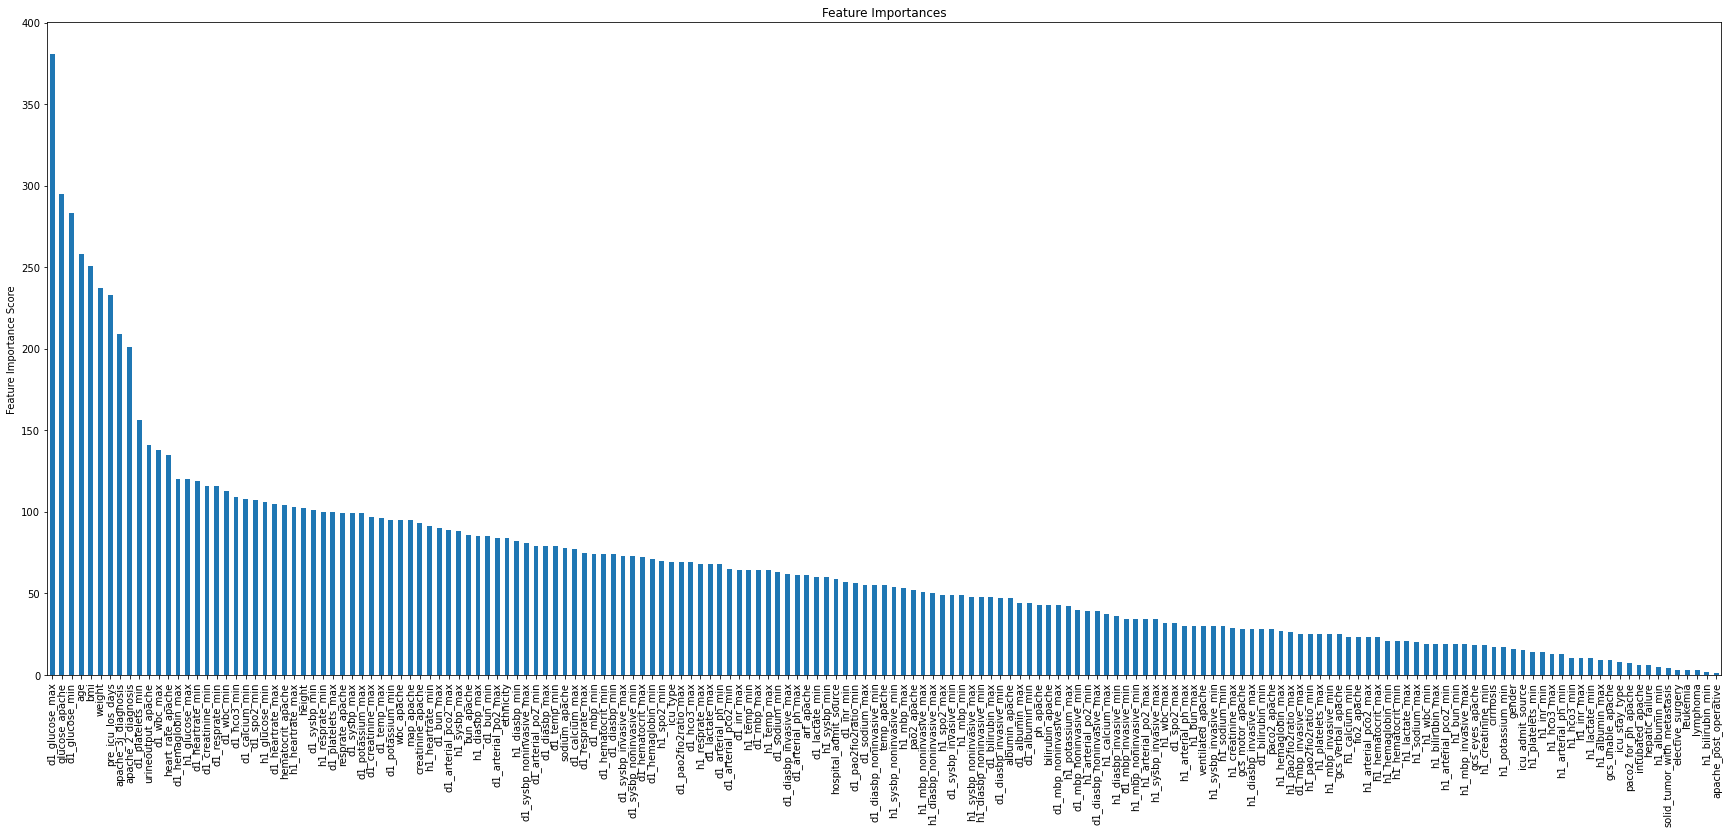

In [14]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

model_fit(xgb1, X_train, y_train, X_test, y_test)

In [15]:
test_params_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

grid_search_1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid = test_params_1, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_1.fit(X_train, y_train)

# grid_search_1.grid_scores_, grid_search_1.best_params_, grid_search_1.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:16:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [16]:
grid_search_1.best_params_, grid_search_1.best_score_

({'max_depth': 7, 'min_child_weight': 5}, 0.8536374861761346)

In [17]:
test_params_2 = {
 'max_depth':[6, 7, 8],
 'min_child_weight':[4, 5, 6]
}

grid_search_2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid=test_params_2, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_2.fit(X_train, y_train)

grid_search_2.best_params_, grid_search_2.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:33:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 7, 'min_child_weight': 5}, 0.8536374861761346)

In [18]:
test_params_3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

grid_search_3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid=test_params_3, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_3.fit(X_train, y_train)

grid_search_3.best_params_, grid_search_3.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:40:37] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.0}, 0.8521503620529817)

Accuracy : 0.8807
AUC Score (Train): 0.926811
AUC Score (Test): 0.853871


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


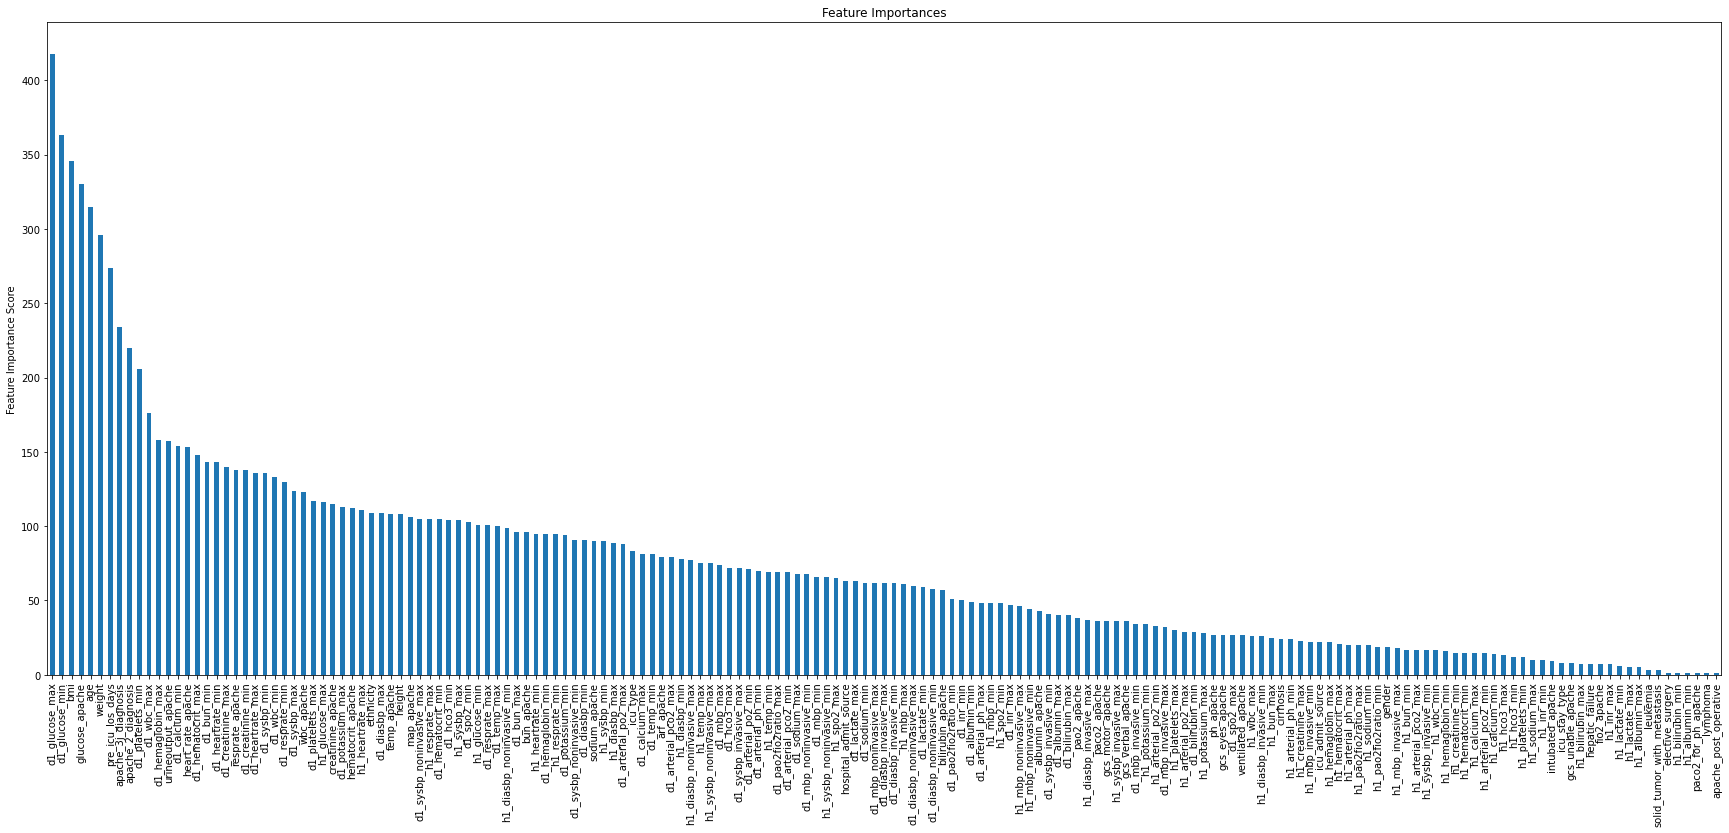

In [19]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

model_fit(xgb2, X_train, y_train, X_test, y_test)

In [20]:
test_params_4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid_search_4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid=test_params_4, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_4.fit(X_train, y_train)

grid_search_4.best_params_, grid_search_4.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:11:24] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8521503620529817)

In [21]:
test_params_5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

grid_search_5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                            param_grid=test_params_5, scoring='roc_auc',n_jobs=4, cv=5)

grid_search_5.fit(X_train, y_train)

grid_search_5.best_params_, grid_search_5.best_score_

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:24:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1}, 0.8522408955185959)

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy : 0.8662
AUC Score (Train): 0.908452


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


AUC Score (Test): 0.854488


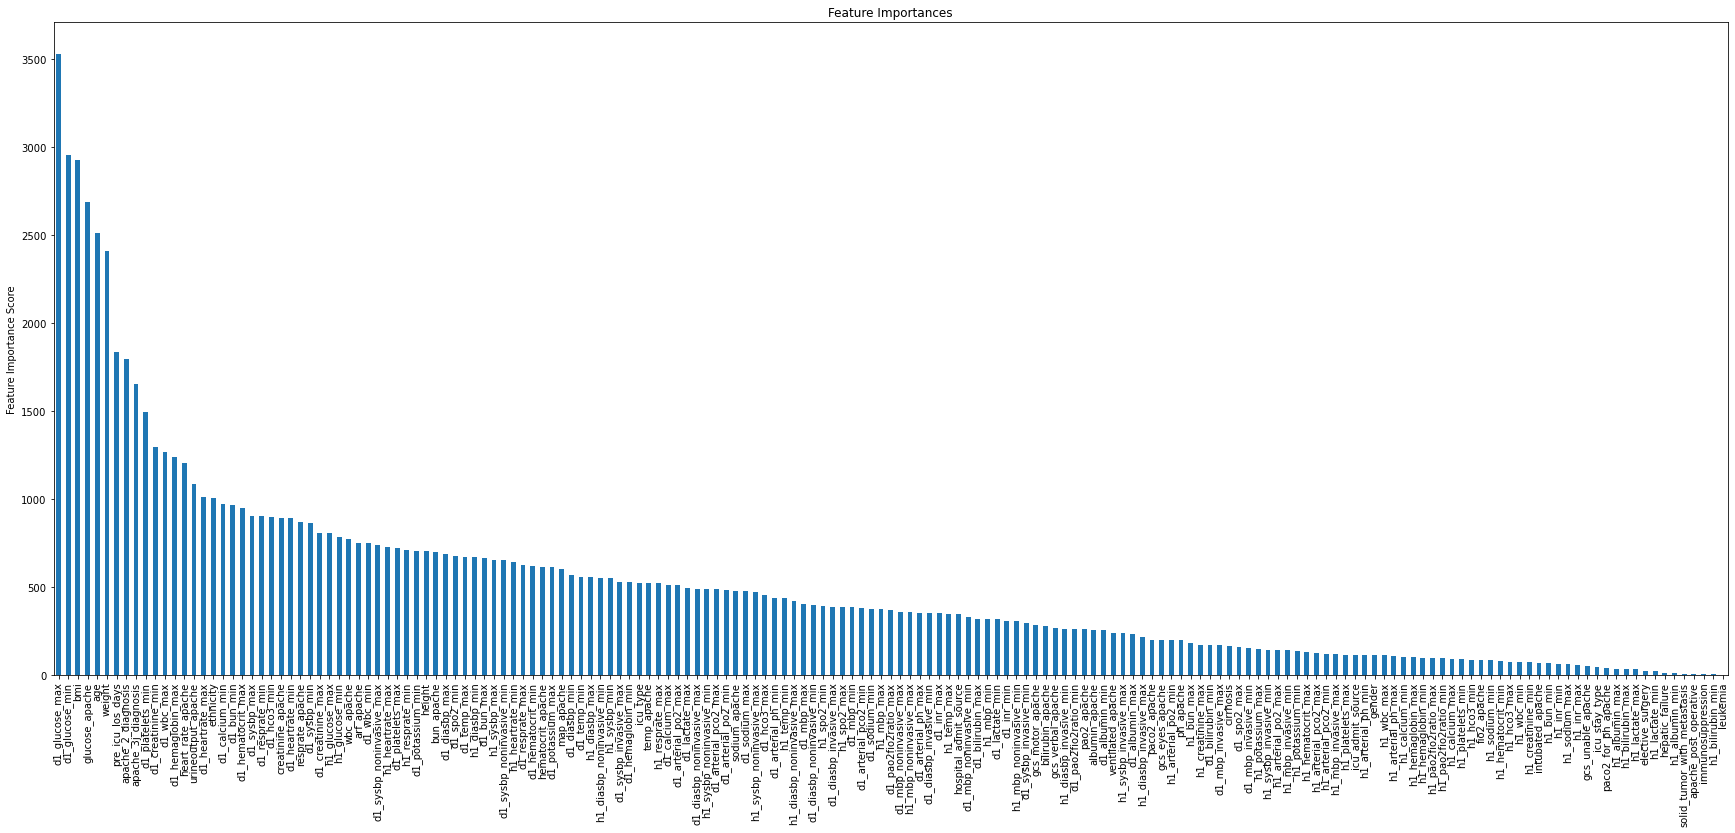

In [23]:
xgb3 = XGBClassifier(learning_rate=0.01,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

model_fit(xgb3, X_train, y_train, X_test, y_test)

In [27]:
y_preds = xgb3.predict(X_test)
score = 0.854488
xgboost_model_results = calculate_scores("xgboost", y_test, y_preds, score)
model_results.append(xgboost_model_results)
model_results

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[{'model': 'Ridge Classifier',
  'roc_auc_score': 0.8231175930359791,
  'precision': 0.6420250896057348,
  'recall': 0.25658012533572067,
  'f1_score': 0.36663681719329666},
 {'model': 'xgboost',
  'roc_auc_score': 0.854488,
  'precision': 0.6538363497323477,
  'recall': 0.459265890778872,
  'f1_score': 0.5395456457719816}]

#### LightGBM Classifier

In [29]:
def lgbm_hyp_tune(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ), 
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [34]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
optimizing_func = lambda trial: lgbm_hyp_tune(trial, X, y)
study.optimize(optimizing_func, n_trials=20)

[I 2022-07-05 13:06:03,523] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=10.651628581829081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.651628581829081
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-07-05 13:07:08,498] Trial 0 finished with value: 0.38435165872187665 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15431405585208238, 'num_leaves': 2840, 'max_depth': 12, 'min_data_in_leaf': 3200, 'lambda_l1': 55, 'lambda_l2': 55, 'min_gain_to_split': 10.651628581829081, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.38435165872187665.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=13.114075806404546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.114075806404546
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

[I 2022-07-05 13:08:09,224] Trial 1 finished with value: 0.3776971223537702 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09644148606735778, 'num_leaves': 1840, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 10, 'lambda_l2': 15, 'min_gain_to_split': 13.114075806404546, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.3776971223537702.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=13.48551428040437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.48551428040437
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Wa

[I 2022-07-05 13:08:30,189] Trial 2 finished with value: 0.4058220953492719 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18077106028201753, 'num_leaves': 2320, 'max_depth': 8, 'min_data_in_leaf': 9100, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 13.48551428040437, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.3776971223537702.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=5.597140278234481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.597140278234481
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Wa

[I 2022-07-05 13:09:35,482] Trial 3 finished with value: 0.39681772242261726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06219687554317789, 'num_leaves': 1760, 'max_depth': 8, 'min_data_in_leaf': 9500, 'lambda_l1': 15, 'lambda_l2': 95, 'min_gain_to_split': 5.597140278234481, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.3776971223537702.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=3.2916985248210096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2916985248210096
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-07-05 13:10:16,077] Trial 4 finished with value: 0.38062644271400303 and parameters: {'n_estimators': 10000, 'learning_rate': 0.211746454932866, 'num_leaves': 2340, 'max_depth': 10, 'min_data_in_leaf': 5000, 'lambda_l1': 65, 'lambda_l2': 20, 'min_gain_to_split': 3.2916985248210096, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.3776971223537702.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=8.26863758234797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.26863758234797
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-05 13:10:17,418] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2022-07-05 13:10:19,509] Trial 6 pruned. Trial was pruned at iteration 39.
[I 2022-07-05 13:10:21,193] Trial 7 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=2.2476249230781074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2476249230781074
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2022-07-05 13:10:50,276] Trial 8 finished with value: 0.37545975037855694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19755681639001166, 'num_leaves': 2600, 'max_depth': 11, 'min_data_in_leaf': 2300, 'lambda_l1': 5, 'lambda_l2': 25, 'min_gain_to_split': 2.2476249230781074, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: 0.37545975037855694.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5388500703565519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5388500703565519
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-05 13:10:51,783] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2022-07-05 13:10:53,408] Trial 10 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.5300333095548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.5300333095548
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] m

[I 2022-07-05 13:11:35,579] Trial 11 finished with value: 0.38009145333930394 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12884566680324824, 'num_leaves': 1500, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 20, 'lambda_l2': 0, 'min_gain_to_split': 14.5300333095548, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 8 with value: 0.37545975037855694.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=10.670687457676923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.670687457676923
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2022-07-05 13:12:08,106] Trial 12 finished with value: 0.37741121381687154 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22777213274297053, 'num_leaves': 2300, 'max_depth': 10, 'min_data_in_leaf': 2300, 'lambda_l1': 5, 'lambda_l2': 25, 'min_gain_to_split': 10.670687457676923, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: 0.37545975037855694.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=10.103712735130504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.103712735130504
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-05 13:12:09,980] Trial 13 pruned. Trial was pruned at iteration 34.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=10.705615331074661, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.705615331074661
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4

[I 2022-07-05 13:12:43,167] Trial 14 finished with value: 0.3789982992949839 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19060855661205203, 'num_leaves': 2960, 'max_depth': 11, 'min_data_in_leaf': 4500, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 10.705615331074661, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: 0.37545975037855694.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=8.668178670281524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.668178670281524
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=190

[I 2022-07-05 13:13:23,462] Trial 15 finished with value: 0.37937569420839395 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29214316460640005, 'num_leaves': 2200, 'max_depth': 9, 'min_data_in_leaf': 1900, 'lambda_l1': 30, 'lambda_l2': 0, 'min_gain_to_split': 8.668178670281524, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: 0.37545975037855694.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=3.047803995321314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.047803995321314
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-05 13:13:25,504] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2022-07-05 13:13:27,308] Trial 17 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.1271370855763365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1271370855763365
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warn

[I 2022-07-05 13:13:56,589] Trial 18 finished with value: 0.37315035803507873 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2084727384583134, 'num_leaves': 2560, 'max_depth': 9, 'min_data_in_leaf': 1600, 'lambda_l1': 0, 'lambda_l2': 40, 'min_gain_to_split': 2.1271370855763365, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 18 with value: 0.37315035803507873.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.3452500996250625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3452500996250625
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-05 13:13:58,375] Trial 19 pruned. Trial was pruned at iteration 0.


In [35]:
study.best_value, study.best_params

(0.37315035803507873,
 {'n_estimators': 10000,
  'learning_rate': 0.2084727384583134,
  'num_leaves': 2560,
  'max_depth': 9,
  'min_data_in_leaf': 1600,
  'lambda_l1': 0,
  'lambda_l2': 40,
  'min_gain_to_split': 2.1271370855763365,
  'bagging_fraction': 0.6000000000000001,
  'bagging_freq': 1,
  'feature_fraction': 0.8})

In [43]:
model = lgbm.LGBMClassifier(objective="binary", **study.best_params, eval_set=[(X_test, y_test)])
model.fit(X_train, y_train)

[LightGBM] [Warning] 0 is set=, 0= will be ignored. Current value: 0=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 1 is set=, 1= will be ignored. Current value: 1=
[LightGBM] [Warning] 1 is set=, 1= will be ignored. Current value: 1=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 0 is set=, 0= will be ignored. Current value: 0=
[LightGBM] [Warning] 0 is set=, 0= will be ignored. Current value: 0=
[LightGBM] [Warning] 2 is set=, 2= will be ignored. Current value: 2=
[LightGBM] [Warning] 1 is set=, 1= will be ignored. Current value: 1=
[LightGBM] [Warning] 1 is set=, 1= will be ignored. Current value: 1=
[LightGBM] [Warning] 0 is set=, 0= will be ignored. Current value: 0=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[L

LGBMClassifier(bagging_fraction=0.6000000000000001, bagging_freq=1,
               eval_set=[(         age        bmi  elective_surgery  ethnicity  gender  height  \
61393   67.0  22.153416                 0          2       1   175.2   
86153   63.0  25.464011                 0          2       1   188.0   
110958  60.0  28.515625                 1          2       0   160.0   
124312  76.0  26.255952                 0          2       1   166.4   
93372   40.0  21.965300                 1          5       0   167.6   
...      ...        ...               ...        ...     ...     ...   
65585   76.0  22.272709                 1          2       0   157.0   
114378  55.0  25.407311                 0          2       1   170.2   
96066   72.0  31.875000                 0          2       0   16...
73023                             0  
47340                             0  

[25709 rows x 175 columns],
                          61393     0
86153     0
110958    0
124312    0
93372     

In [45]:
y_preds = model.predict(X_test)
score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
lgbm_model_score = calculate_scores("lgbm", y_test, y_preds, score)
lgbm_model_score

{'model': 'lgbm',
 'roc_auc_score': 0.8352635593074059,
 'precision': 0.6059437386569873,
 'recall': 0.4782452999104745,
 'f1_score': 0.5345742019413589}

In [47]:
model_results.append(lgbm_model_score)

#### Comparison of Algorithms

<AxesSubplot:xlabel='model'>

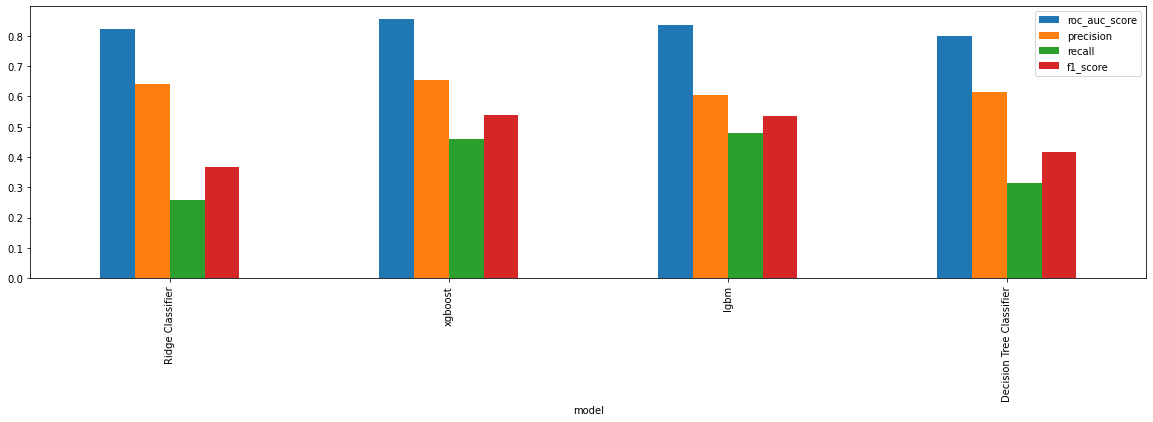

In [108]:
score_df = pd.DataFrame(model_results)
score_df.plot(kind="bar", x="model", y=["roc_auc_score", "precision", "recall", "f1_score"], figsize=(20, 5))

In [109]:
score_df

,model,roc_auc_score,precision,recall,f1_score
0,Ridge Classifier,0.823118,0.642025,0.256580,0.366637
1,xgboost,0.854488,0.653836,0.459266,0.539546
2,lgbm,0.835264,0.605944,0.478245,0.534574
3,Decision Tree Classifier,0.798157,0.614711,0.314235,0.415877
